# Example about OpenVisus filters

Import OpenVisus and define utils:

In [52]:
import os,sys
import numpy as np
from PIL import Image
from urllib.request import urlopen
import matplotlib.pyplot as plt
import shutil

# import OpenVisus
# sys.path.append(r"C:\projects\OpenVisus\build\RelWithDebInfo")
from OpenVisus import *

# utility
def LoadImage(filename):
	if filename.startswith('http'):
		filename=urlopen(filename) 
	return numpy.asarray(Image.open(filename))

# utility
def ShowImage(data,width=10):
	ratio=float(data.shape[1])/data.shape[0]
	fig = plt.figure(figsize = (width,width*ratio))
	ax = fig.add_subplot(1,1,1)
	ax.imshow(data, origin='lower',cmap='viridis')
	plt.show()

Import your source data:

In [53]:
dtype=np.float32
width,height,depth=1407,389,1388
num_channels=1

bGenerateFakeData=True

if bGenerateFakeData:
    # example of generating fake data (a white square in the middle)
    data = np.zeros((depth, height, width,num_channels), dtype)
    data[int(depth*1/4):int(depth*3/4),int(height*1/4):int(height*3/4),int(width*1/4):int(width*3/4), 0] = 1.0
else:
    # example of loading a file from *.raw file
    filename=r'volume_1407x389x1388_float32.raw'
    data = np.fromfile(filename, dtype=dtype).reshape((depth, height, width, num_channels))

print("Loaded data",data.shape,data.dtype)
#ShowImage(data[int(depth/2),:,:,0])

Loaded data (1388, 389, 1407, 1) float32


About filters:
- `identity` does NOT need an extra channel
- `min` | `max` needs an extra channel (this about this: when I apply the inverse filter I need a way to know the original ordering)
- discrete  `wavelet` (intXX)  needs an extra channel
- continuos `wavelet` (floatXX) does NOT need an extra channel

I need an extra channle for `max` filter:

In [54]:
num_channels+=1
new_data=numpy.zeros((depth, height, width, num_channels),dtype=data.dtype)
new_data[:,:,:,0]=data[:,:,:,0]
data=new_data
print("Extra channel added", data.shape, data.dtype)

Extra channel added (1388, 389, 1407, 2) float32


Create the IDX directory from data. 
Note we are disabling compression here (`raw`) since `zip` is really slow. But in production you may want to use `zip` or `lz4`.

In [56]:
idx_filename='tmp/honeycomb_max_py.idx'
print("Creating idx...")
compression="raw"

bDataInMemory=False

# remove old directory if exists
shutil.rmtree(os.path.dirname(idx_filename), ignore_errors=True)

# example of writing data already in memory
if bDataInMemory:
    db = CreateIdx(
        url=idx_filename, 
        dim=3, 
        data=data, 
        filters=['max'],
        compression=compression)

# example of writing data slice by slice (i.e. data not fitting in memory)
else:
    field=Field.fromString("DATA float32[{}] default_layout(row_major)".format(num_channels))
    db = CreateIdx(
        url=idx_filename, 
        dim=3, 
        dims=(width,height,depth),
        filters=['max'],
        fields=[field],
        compression=compression) 
    
    # # z y x channel
    # NOTE: if you have a row-major file here you need to read the file in place and return the data
    def generateSlices():
        for I in range(depth): 
            #print("Generating slice",I)
            yield data[I,:,:,:] 

    # NOTE: internally writeSlabs will accumulate slices up to some max_memsizse to maximize conversion speed
    GB=1024*1024*1024
    db.writeSlabs(generateSlices(),max_memsize=4*GB)

print("idx file created")

Creating idx...
Writing data...
idx file created


Compute filter using a "sliding window" (sliding_box will be sliding_window^dim)

In [48]:
print("Computing filter...")
sliding_window=1024
db.computeFilter(idx.getField(), sliding_window)
print("done")

Computing filter...
Filter computed


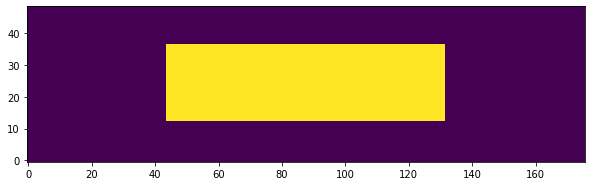

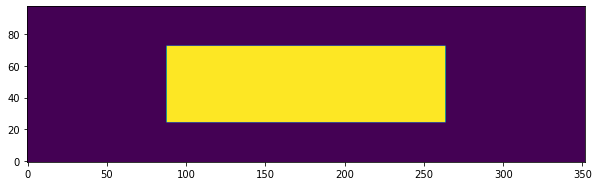

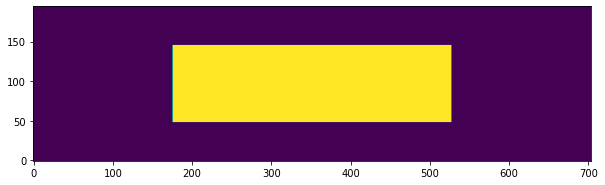

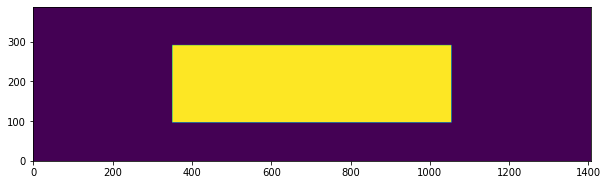

In [60]:
"""
in general read will return a 3D region with 2 channels
you need to 
    (*) get the first slice in Z of the the 3D block
    (*) get the first channel (==drop the filter extra channel) 
""" 
middle=int(depth/2)
for img in db.read(z=[middle,middle+1],num_refinements=4):
    ShowImage(img[0,:,:,0] )